In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
plt.rcParams['animation.html'] = 'html5'
import numpy as np
import scipy as sp
import scipy.integrate
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from spectral import *
np.set_printoptions(linewidth=120)

In [15]:
L, Hy, Hz = 4800//3, 10, 10 # millimeters
mesh_x = Multidomain(Legendre(12), np.linspace(0, L, 240//3 + 1))
mesh_y = Legendre(6, (-Hy/2, Hy/2))
mesh_z = Legendre(6, (-Hz/2, Hz/2))
mesh = mesh_x*mesh_y*mesh_z

rho = 1.06; young = 3.7; nu = 0.34; l = -18.9; m = -13.3; n = -10.0 # PS
#rho = 1.18; young = 5; nu = 0.34; l = -18.9; m = -13.3; n = -10.0 # PMMA (?)
#rho = 8.4; young = 110; nu = 0.34 # brass
lam = young*nu/(1 + nu)/(1 - 2*nu)
mu = young/2/(1 + nu)

In [3]:
def cauchy_green(u):
    deform = u.grad()
    return 1/2*(deform + deform.T + deform@deform.T)

def kin_energy(v):
    return rho*(v@v).int()/2

def pot_energy(u):
    CG = cauchy_green(u)
    I1 = CG.trace()
    I2 = 1/2*(CG.trace()**2 - (CG@CG.T).trace())
    I3 = CG.det()
    pot = (lam/2 + mu)*I1**2 - 2*mu*I2 + (l + 2*m)/3*I1**3 - 2*m*I1*I2 + n*I3
    return pot.int()

def energy(u, v):
    return kin_energy(v) + pot_energy(u)

In [8]:
def compress(u, v):
    return np.stack((u.func, v.func)).ravel()

def decompress(y):
    func_u, func_v = y.reshape(2, 3, *mesh.shape)
    u = TensorField(mesh, func_u)
    v = TensorField(mesh, func_v)
    return u, v

def derivative(t, y):
    u, v = decompress(y)
    du_dt = v
    
    CG = cauchy_green(u)
    I1 = CG.trace()
    I2 = 1/2*(CG.trace()**2 - (CG@CG.T).trace())
    dI1 = np.eye(3)
    dI2 = dI1*CG.trace() - CG
    dI3 = CG.cofactor_matrix()
    
    PK = ((lam + 2*mu)*I1*dI1 - 2*mu*dI2 + (l + 2*m)*I1**2*dI1 
          - 2*m*(dI1*I2 + I1*dI2) + n*dI3)@(np.eye(3) + u.grad())
    
    bval = (f(t), 0), (0, 0), (0, 0)
    F = PK.div(bval)
    
    #bval = (0, 0), (0, 0), (0, 0)
    #friction = 0.6
    #F += friction*v.grad().div(bval)
    
    F = F.match_domains()    
    dv_dt = F/rho
    
    return compress(du_dt, dv_dt)

# Check the energy conservation

In [5]:
# Rotation
u0 = TensorField(mesh, 1e-4*np.random.randn(3, *mesh.shape))
f0 = u0.func
X, Y, Z = mesh.grid()
xyz = np.array(np.meshgrid(X, Y, Z, indexing='ij'))
R = np.linalg.qr(np.random.randn(3, 3))[0]
f1 = np.tensordot(R, f0 + xyz, (-1, 0)) - xyz
u1 = TensorField(mesh, f1)
(pot_energy(u0) - pot_energy(u1))/pot_energy(u0)

3.478378065411153e-12

In [342]:
np.linalg.norm(cauchy_green(u0).func - cauchy_green(u1).func)/np.linalg.norm(cauchy_green(u0).func)

5.847224422695232e-10

In [343]:
t0 = 0
t_max = 0.1
dt = 0.01
T = np.arange(t0, t_max + dt/2, dt)
u0 = TensorField(mesh, 1e-3*np.random.randn(3, *mesh.shape))
v0 = TensorField(mesh, 0*np.random.randn(3, *mesh.shape))

U = TensorField(mesh, np.zeros((len(T), 3) + mesh.shape))
V = TensorField(mesh, np.zeros((len(T), 3) + mesh.shape))
E = np.zeros(len(T))

def f(t):
    return 0

In [344]:
%timeit derivative(0, compress(u0, v0))

12.9 ms ± 86 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [345]:
%%time
r = sp.integrate.ode(derivative).set_integrator('dop853', rtol=1e-10, atol=1e-10, nsteps=1e4)
r.set_initial_value(compress(u0, v0), t=t0)
for k, t in enumerate(Progress(T)):
    if t > r.t:
        r.integrate(t)
    U[k], V[k] = decompress(r.y)
    E[k] = energy(U[k], V[k])

HTML(value='')

CPU times: user 8.02 s, sys: 132 ms, total: 8.15 s
Wall time: 2.04 s


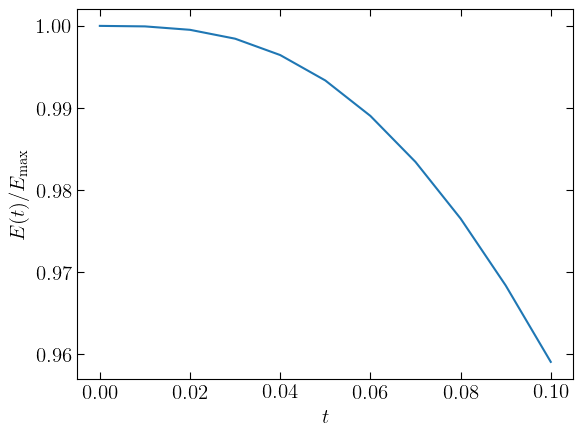

In [346]:
plt.plot(T, E/E.max())
plt.xlabel(r'$t$')
plt.ylabel(r'$E(t)/E_{\rm max}$')
plt.show()

# Boundary impact

In [16]:
%%time
tau = 4
t0 = -8*tau
t_max = 5/12*L
dt = 1.0
F0 = 0.3
T = np.arange(t0, t_max + dt/2, dt)
u0 = TensorField(mesh, np.zeros((3,) + mesh.shape))
v0 = TensorField(mesh, np.zeros((3,) + mesh.shape))

U = TensorField(mesh, np.zeros((len(T), 3) + mesh.shape))
V = TensorField(mesh, np.zeros((len(T), 3) + mesh.shape))
E = np.zeros(len(T))

def f(t):
    F = F0*np.exp(-t**2/2/tau**2), 0, 0
    return np.asarray(F)[:,None,None]


r = sp.integrate.ode(derivative).set_integrator('dop853', rtol=1e-10, atol=1e-10, nsteps=1e4)
r.set_initial_value(compress(u0, v0), t=t0)
for k, t in enumerate(Progress(T)):
    if t > r.t:
        r.integrate(t)
    U[k], V[k] = decompress(r.y)
    E[k] = energy(U[k], V[k])

HTML(value='')

CPU times: user 1h 19min 28s, sys: 2min 52s, total: 1h 22min 20s
Wall time: 41min 10s


In [17]:
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
plt.xlim(0, L)
plt.ylim(-0.1, 0.3)
line, = ax.plot([], [])
time_template = 'time = %.1f us'
time_text = ax.text(0.75, 0.9, '', transform=ax.transAxes)
plt.xlabel(r'$x$, mm')
plt.ylabel(r'$-U_x(x, 0, 0)/F_0$')
plt.minorticks_on()
plt.close()

def animate(k):
    x = np.linspace(0, L, 2000)
    u = -U[k, 0](None, 0, 0).diff()(x)
    line.set_data(x, u)
    time_text.set_text(time_template % T[k])
    return line, time_text

anim = animation.FuncAnimation(fig, animate, 
                               frames=len(T), interval=50, blit=True)

In [18]:
anim # be patient

In [29]:
U[1, 0](None, 0, 0).diff()(x).shape

(2000,)

In [25]:
np.save('strain_L=1600.npy', -U[:, 0](None, 0, 0).diff()(x))

In [371]:
FWHM = np.zeros(len(T))
A = np.zeros(len(T))
B = np.zeros(len(T))
X = np.zeros(len(T))
x = np.linspace(0, L, 2000)
xmin = 10
for k in Progress(len(T)):
    u = -U[k, 0](None, 0, 0).diff()(x)/F0
    A[k] = np.max(u)
    B[k] = np.min(u[x > xmin])
    i = np.argmax(u)
    X[k] = x[i]
    x2 = np.interp(A[k]/2, u[i:][::-1], x[i:][::-1])
    x1 = np.interp(A[k]/2, u[i::-1][::-1], x[i::-1][::-1])
    FWHM[k] = x2 - x1

HTML(value='')

Text(0,0.5,'Amplitude (arb. units)')

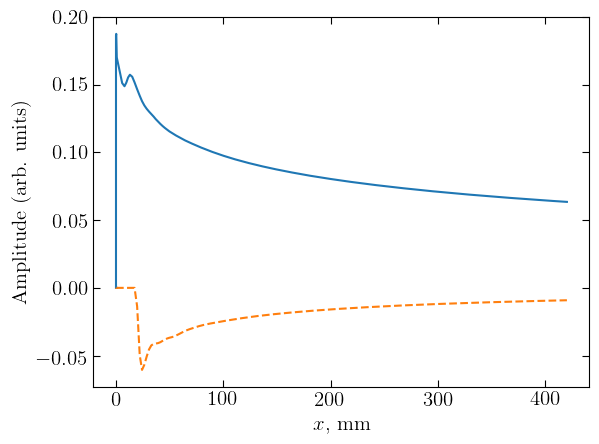

In [372]:
plt.plot(X, A)
plt.plot(X, B, '--')
plt.xlabel(r'$x$, mm')
plt.ylabel('Amplitude (arb. units)')

Text(0,0.5,'FWHM')

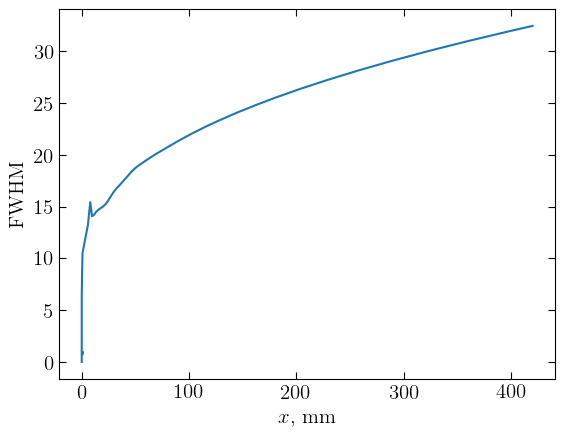

In [373]:
plt.plot(X, FWHM)
plt.xlabel(r'$x$, mm')
plt.ylabel('FWHM')

In [ ]:
np.savetxt('Soliton_%g.dat' % F0, np.column_stack((T, X, A, B, FWHM)))

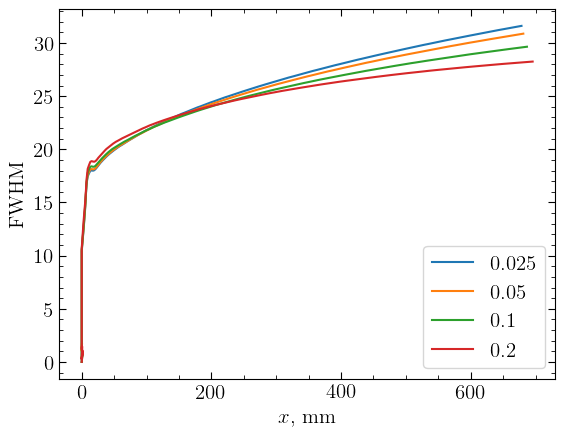

In [389]:
for F0_ in (0.025, 0.05, 0.1, 0.2):#, 0.3, 0.4, 0.5, 0.6):
    T_, X_, A_, B_, FWHM_ = np.loadtxt('Soliton_%g.dat' % F0_).T
    plt.plot(X_, FWHM_, label=F0_)
plt.legend()
plt.xlabel(r'$x$, mm')
plt.ylabel('FWHM')
plt.minorticks_on()
fig = plt.gcf()

In [390]:
fig.savefig('FWHM.pdf')

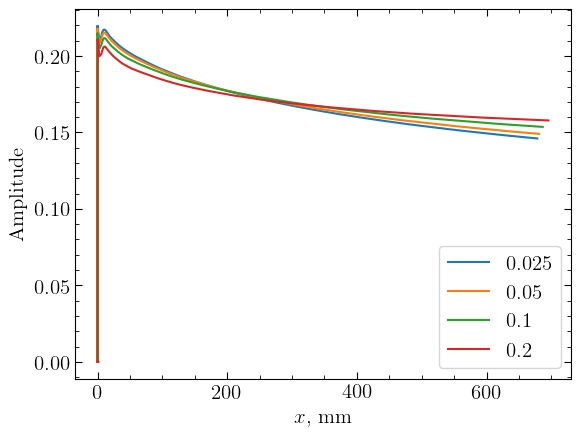

In [391]:
for F0_ in (0.025, 0.05, 0.1, 0.2):#, 0.3, 0.4, 0.5, 0.6):
    T_, X_, A_, B_, FWHM_ = np.loadtxt('Soliton_%g.dat' % F0_).T
    plt.plot(X_, A_, label=F0_)
plt.legend()
plt.xlabel(r'$x$, mm')
plt.ylabel('Amplitude')
plt.minorticks_on()
fig = plt.gcf()

In [392]:
fig.savefig('Amplitude.pdf')

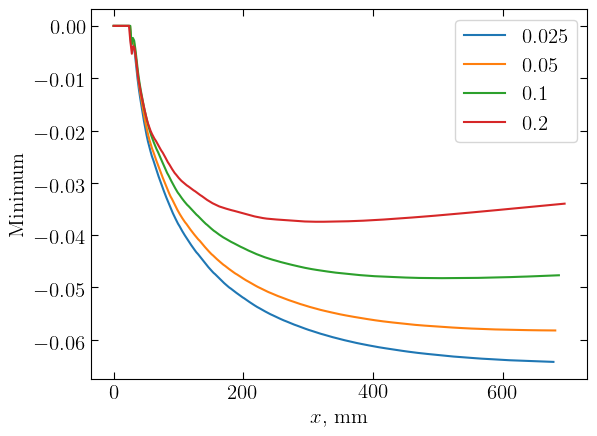

In [386]:
for F0_ in (0.025, 0.05, 0.1, 0.2):#, 0.3, 0.4, 0.5, 0.6):
    T_, X_, A_, B_, FWHM_ = np.loadtxt('Soliton_%g.dat' % F0_).T
    plt.plot(X_, B_, label=F0_)
plt.legend()
plt.xlabel(r'$x$, mm')
plt.ylabel('Minimum')
fig = plt.gcf()

In [295]:
anim # be patient

In [66]:
anim # be patient

(1e-06, 0.47473389120231185)

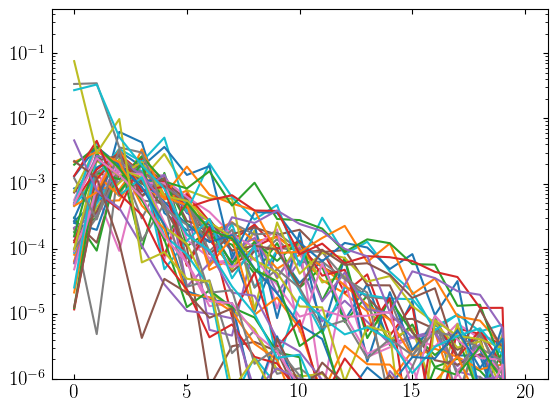

In [11]:
plt.plot(np.abs(U[-1, 0](None, 0, 0).diff().coeff().reshape(-1, mesh_x.domain.N + 1)).T)
plt.yscale('log')
plt.ylim(1e-6, None)

In [13]:
#anim.save('animation.gif', writer='imagemagick', fps=30)
anim.save('animation_nonlin.mp4', fps=30, dpi=100)

In [60]:
np.linalg.norm(U[:,0](None, Hy/2, 0).func - U[:,0](None, -Hy/2, 0).func)

3.4137833522224892e-15

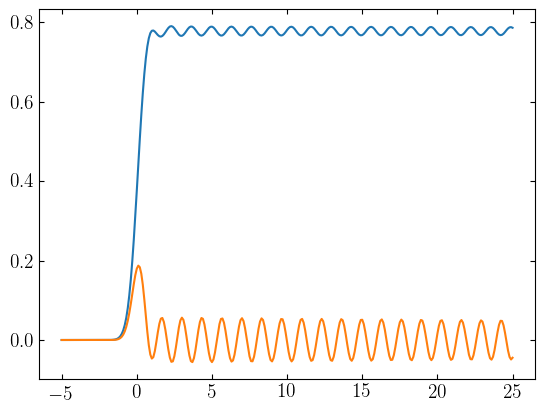

In [102]:
plt.plot(T, U(0,0,0)[:,0])
plt.plot(T, U.diff(1)(0,0,0)[:,1])

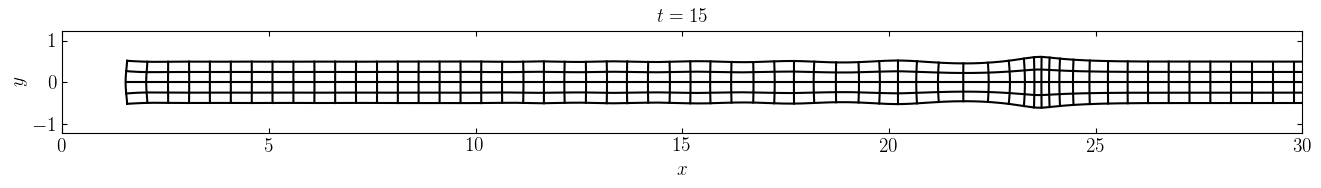

In [76]:
k = -1
t = T[k]
scale = 2
plt.figure(figsize=(16,4))
plt.gca().set_aspect('equal')
for y in np.linspace(-Hy/2, Hy/2, 5):
    u, v, w = U[k](None, y, 0)
    x, = u.mesh(Nx)
    plt.plot(x + scale*u.func(Nx), y + scale*v.func(Nx), 'k')
for x in np.linspace(0, L, 100):
    u, v, w = U[k](x, None, 0)
    y, = u.mesh(Ny)
    plt.plot(x + scale*u.func(Ny), y + scale*v.func(Ny), 'k')    
plt.title(r'$t=%g$' % t)
plt.margins(0, 0.5)
plt.xlim(0, 30)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()


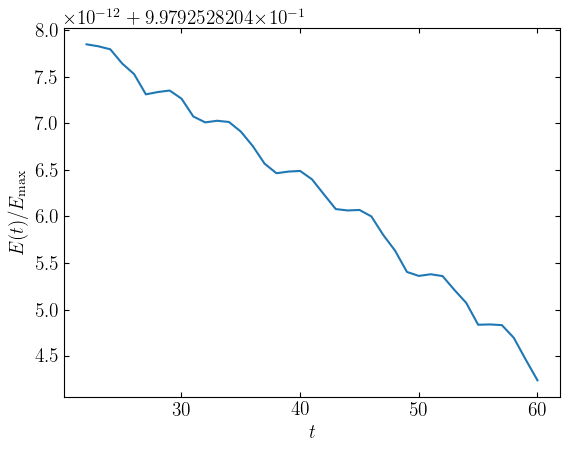

In [75]:
plt.plot(T[T>7*tau], E[T>7*tau]/E.max())
plt.xlabel(r'$t$')
plt.ylabel(r'$E(t)/E_{\rm max}$')
plt.show()

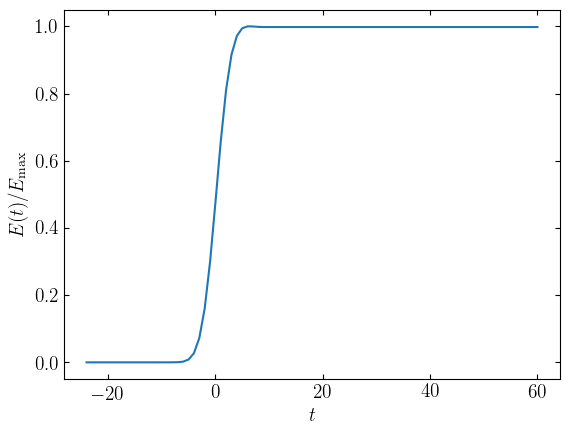

In [74]:
plt.plot(T, E/E.max())
plt.xlabel(r'$t$')
plt.ylabel(r'$E(t)/E_{\rm max}$')
plt.show()